In [2]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
from mne.viz.utils import center_cmap

In [5]:
# [task 2]import .cnt data
# [question] 这里只用了ses-01 的数据，但是实际上sub-002还有其他的数据，并不知道怎么放在一起处理-》分开出去取平均？
fname = "sub-002_ses-01_task-motorimagery_eeg.cnt"
raw = mne.io.read_raw_cnt(input_fname=fname, date_format='dd/mm/yy', preload=True)
raw.info # 用来显示基本的数据

Reading 0 ... 332959  =      0.000 ...   332.959 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 65 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2017-12-13 06:44:38 UTC
 nchan: 65
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

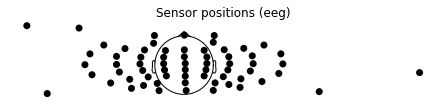

In [6]:
# sensors （before set montage)
raw.plot_sensors()
plt.show()

<ipython-input-8-f6617b6d022a>:30: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


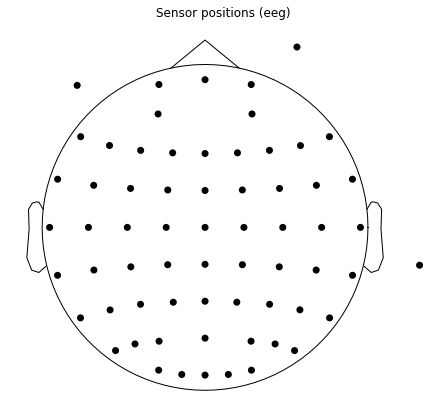

In [8]:
"""
set montage from task-motorimagery_electrodes.tsv
[source] 林沛阳
"""
import csv


def electrodes_read(file_path: str, column_names: list) -> list:
    csv.register_dialect('tsv_dialect', delimiter='\t', quoting=csv.QUOTE_ALL)
    with open(file_path, "r") as wf:
        reader = csv.DictReader(wf, fieldnames=column_names, dialect='tsv_dialect')
        datas = []
        for row in reader:
            datas.append(row)
    csv.unregister_dialect('tsv_dialect')
    dic = {}
    for data in datas:
        if data["name"] == "name":
            continue
        x = float(data["x"]) / 1000
        y = -float(data["y"]) / 1000
        z = float(data["z"]) / 1000
        dic[data["name"]] = [y, x, z]

    montage = mne.channels.make_dig_montage(ch_pos=dic)
    return montage


montage = electrodes_read("task-motorimagery_electrodes.tsv", ["name", "x", "y", "z"])
raw.set_montage(montage)


# sensors （after set montage)
raw.plot_sensors()
plt.show()

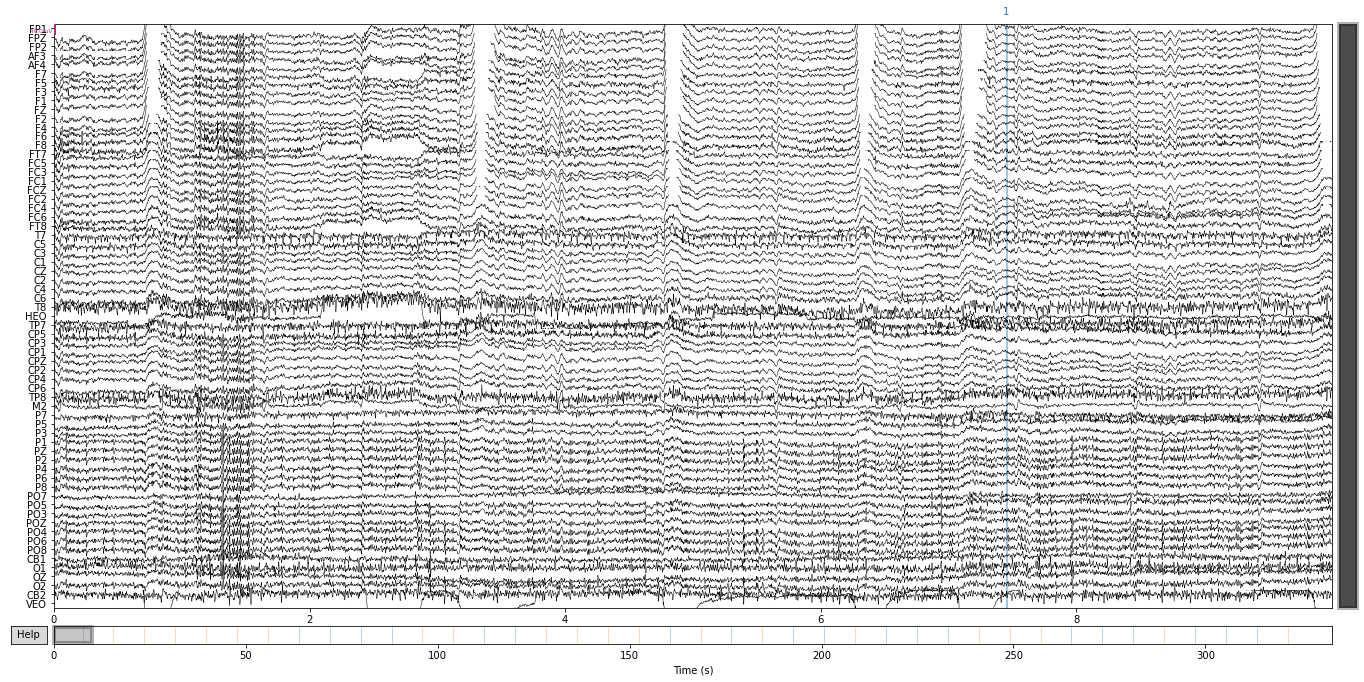

In [9]:
# [task 3]Plot the time course of raw EEG signals with 10-second window
raw.plot(start=0, duration=10, n_channels=65)
plt.show()  # 保持界面显示并且能实现交互，而不是只生成一张png

Effective window size : 2.048 (s)


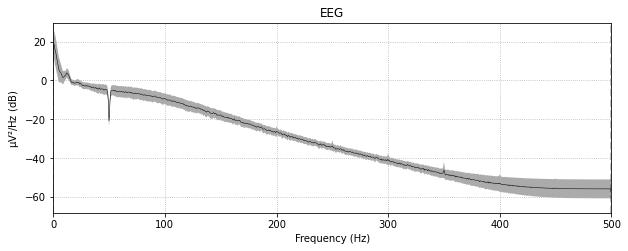

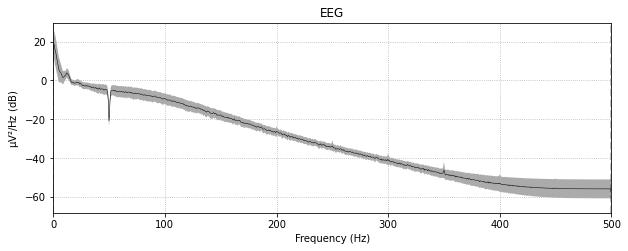

In [10]:
# 查看功率谱的密度 raw
raw.plot_psd(average=True)

In [11]:
"""
[task 4] Data preprocessing, artifacts removal
[source] https://blog.csdn.net/LiDLMU/article/details/109291216
"""

'\n[task 4] Data preprocessing, artifacts removal\n[source] https://blog.csdn.net/LiDLMU/article/details/109291216\n'

In [12]:
# 坏道处理
# [question] 坏道的判断并不是很清楚，从time course那里的线有一些都是断的，所以就盲选了两个
raw.info["bads"] = ['VEO', 'HEO']
raw.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 2 sensors


<RawCNT | sub-002_ses-01_task-motorimagery_eeg.cnt, 65 x 332960 (333.0 s), ~165.2 MB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 sec)

Effective window size : 2.048 (s)


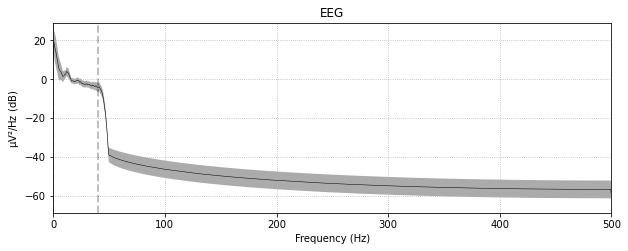

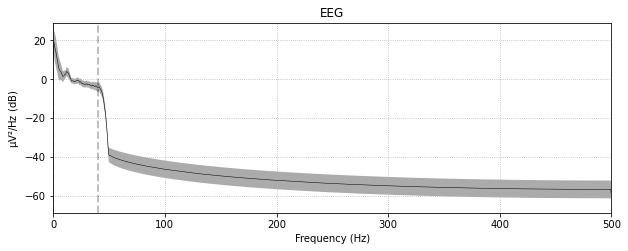

In [13]:
# 0.1-40Hz 滤波
raw.filter(l_freq=0.1, h_freq=40)
# 查看功率谱的密度 raw_pass (这里有一个比较大的变化)
raw.plot_psd(average = True)

In [14]:
# 50 Hz notch filter
raw.notch_filter(freqs=50)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



<RawCNT | sub-002_ses-01_task-motorimagery_eeg.cnt, 65 x 332960 (333.0 s), ~165.2 MB, data loaded>

Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 56.1s.
Creating RawArray with float64 data, n_channels=30, n_times=332960
    Range : 0 ... 332959 =      0.000 ...   332.959 secs
Ready.


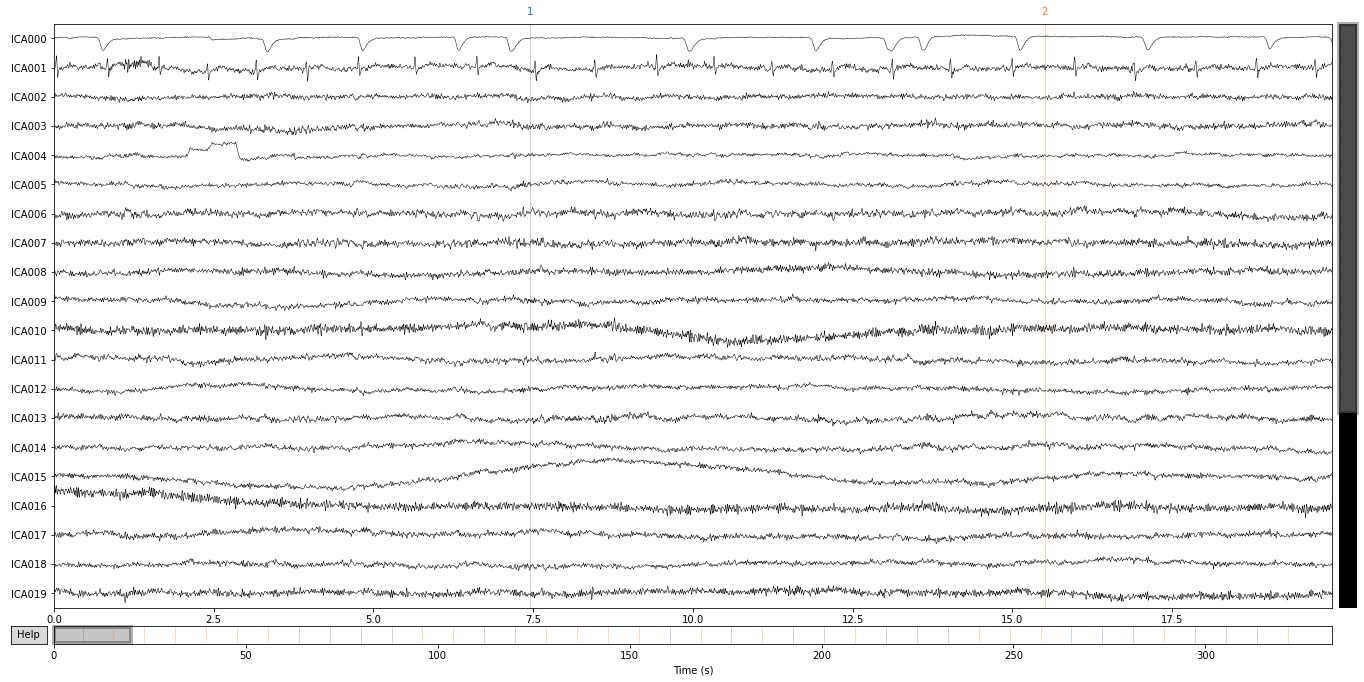

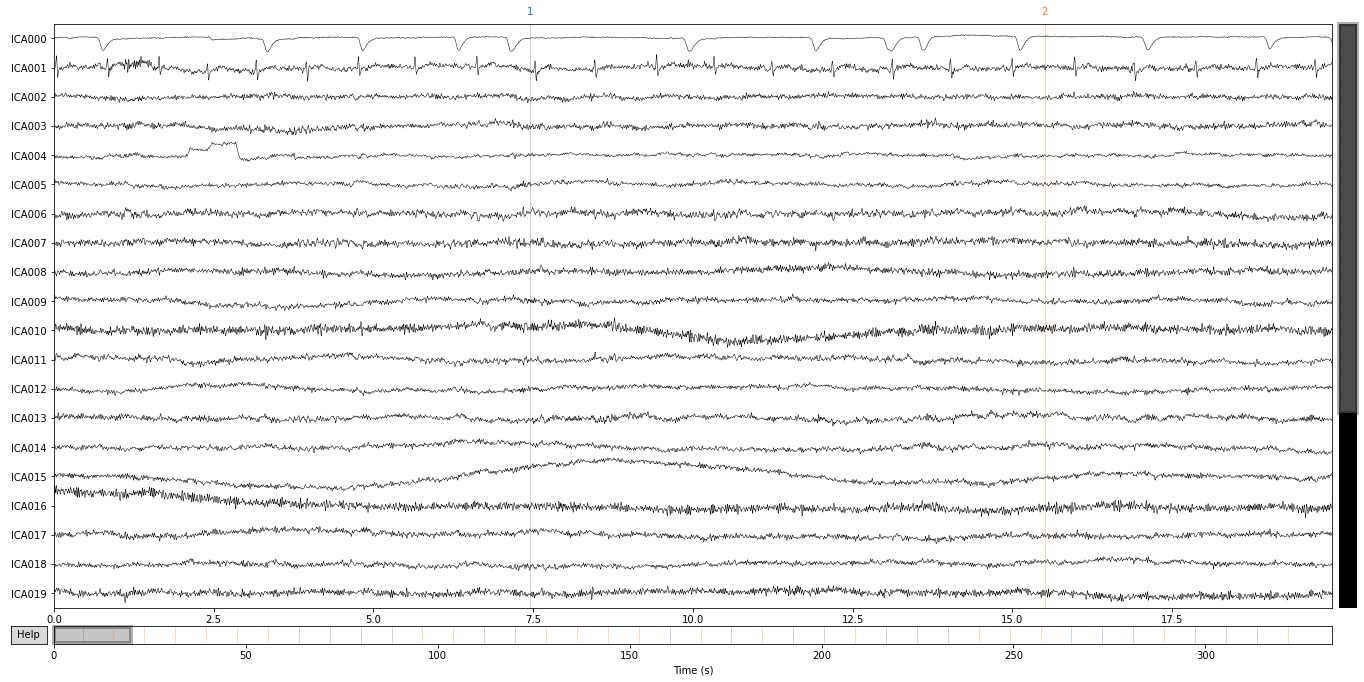

In [16]:
# ICA独立成分分析
from mne.preprocessing import (ICA)
ica = ICA(n_components=30, random_state=97)
ica.fit(raw)
ica.plot_sources(raw) # 这里图变得很奇怪

In [18]:
# 手动选择眼电，心电伪影
ica.exclude = [0, 1]
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 65 PCA components


<RawCNT | sub-002_ses-01_task-motorimagery_eeg.cnt, 65 x 332960 (333.0 s), ~165.2 MB, data loaded>

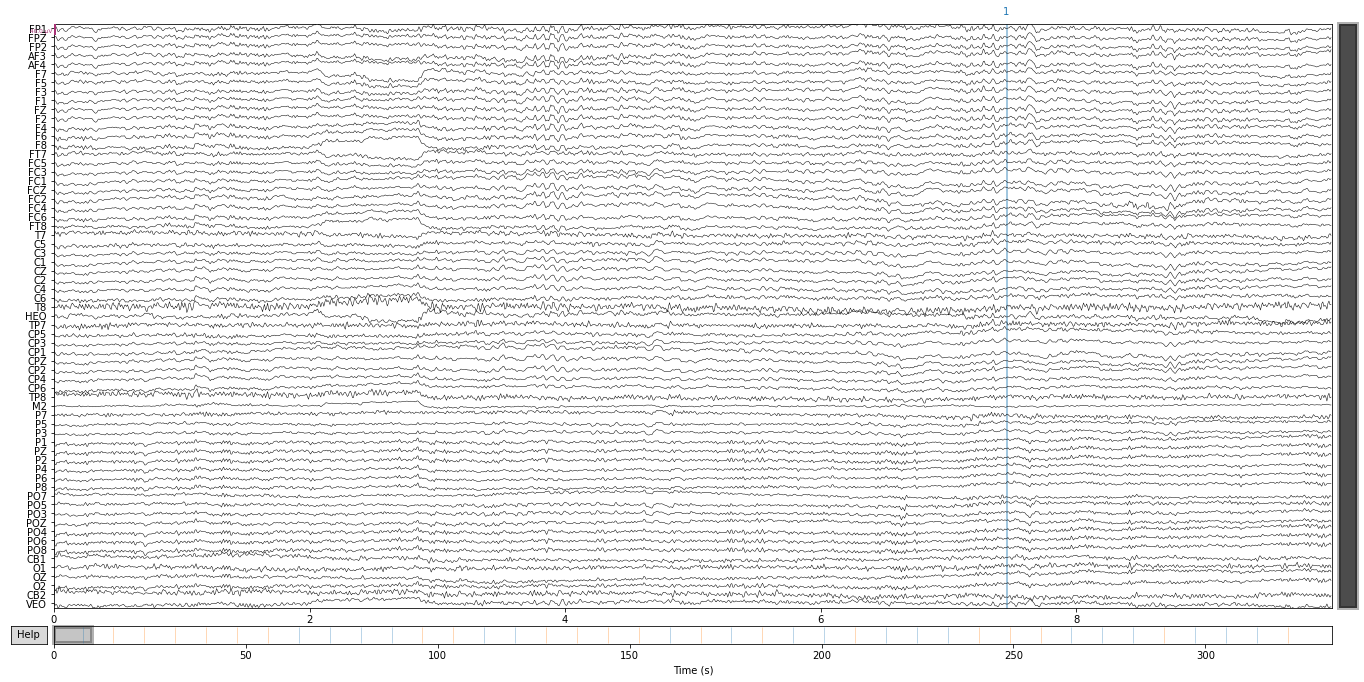

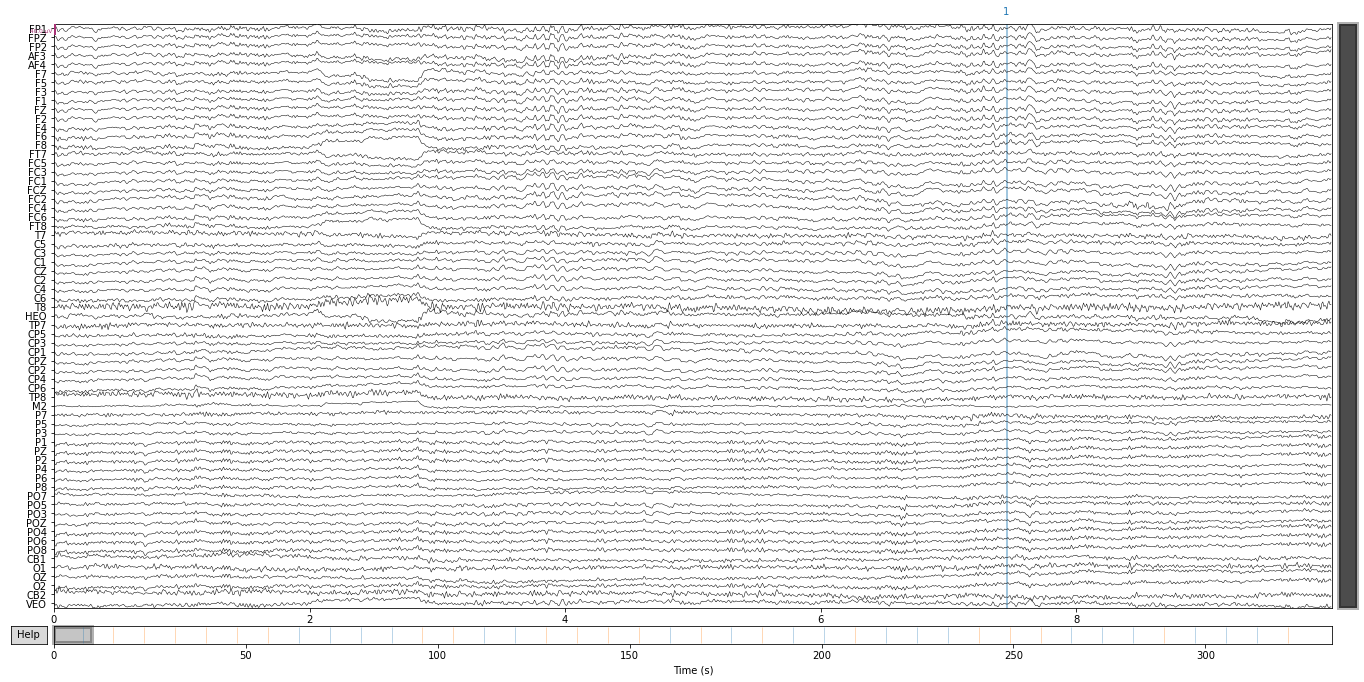

In [20]:
# [task 5]time course （在这里线变得规整起来了）
raw.plot(start=0, duration=10, n_channels=65)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 65 PCA components


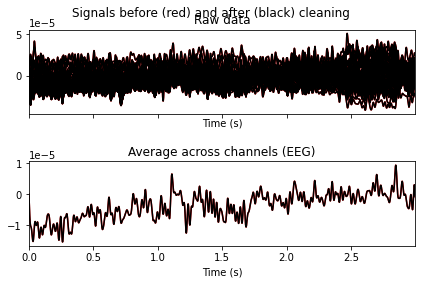

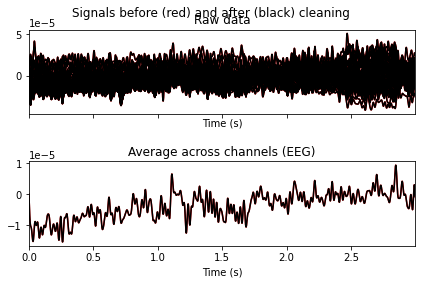

In [21]:
# 比较处理前后的数据
# 注：在这里一直是对raw本身直接进行处理，和将raw.copy得到的效果不太一样
ica.plot_overlay(raw, exclude=[0, 1])

In [23]:
"""
[task 6] Plot the time-frequency maps of the subject
# Authors: Clemens Brunner <clemens.brunner@gmail.com>
# source:https://mne.tools/stable/auto_examples/time_frequency/plot_time_frequency_erds.html?highlight=erd
# License: BSD (3-clause)
"""

'\n[task 6] Plot the time-frequency maps of the subject\n# Authors: Clemens Brunner <clemens.brunner@gmail.com>\n# source:https://mne.tools/stable/auto_examples/time_frequency/plot_time_frequency_erds.html?highlight=erd\n# License: BSD (3-clause)\n'

In [24]:
# events : hand & elbows
# 来自预处理后的 task-motorimagery 的event
events, _ = mne.events_from_annotations(raw)
# [question-undo] 这里的events偶尔会出现大小不对的情况，可能要删掉
# del events["response_time"]
picks = mne.pick_channels(raw.info["ch_names"], ["C3", "CZ", "C4"])

Used Annotations descriptions: ['1', '2']


In [25]:
# events_rest : rest
# 来自什么处理都没做的 sub-002_ses-16_task-rest_eeg.cnt
# 因为上面不包含rest，所以等距构造了一个
# 1810唐家豪 ： 事件间隔基本都是8000ms，4000是事件，剩的就是休息
fname_rest = "sub-002_ses-16_task-rest_eeg.cnt"
raw_rest = mne.io.read_raw_cnt(input_fname=fname_rest, date_format='dd/mm/yy', preload=True)
events_rest = mne.make_fixed_length_events(raw_rest, id=3, start=1.2, duration=4.0, first_samp=True, overlap=0.0)
events_merge = np.append(events, events_rest, axis=0)
event_m_ids = dict(hands=1, elbow=2, rest=3)

tmin, tmax = -1, 4  # define epochs around events (in s)
epochs = mne.Epochs(raw, events_merge, event_m_ids, tmin - 0.5, tmax + 0.5,
                    picks=picks, baseline=None, preload=True)

Reading 0 ... 380839  =      0.000 ...   380.839 secs...
Not setting metadata
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Loading data for 134 events and 6001 original time points ...
13 bad epochs dropped


<ipython-input-25-66eea5aed0f5>:12: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events_merge, event_m_ids, tmin - 0.5, tmax + 0.5,


In [ ]:
# compute ERDS maps ###########################################################
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs  # use constant t/f resolution
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

# Run TF decomposition overall epochs
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=True, return_itc=False, average=False,
                     decim=2)
tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")
# for event in event_ids:
for event in event_m_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1,
                                     **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()

Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.729133
stat_fun(H1): min=-5.640701 max=3.338169
Running initial clustering
Found 58 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.729133
stat_fun(H1): min=-5.640701 max=3.338169
Running initial clustering
Found 62 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-4.340735 max=3.850237
Running initial clustering
Found 76 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.729133
stat_fun(H1): min=-4.340735 max=3.850237
Running initial clustering
Found 53 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-4.674068 max=3.269551
Running initial clustering
Found 72 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.729133
stat_fun(H1): min=-4.674068 max=3.269551
Running initial clustering
Found 48 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied


<ipython-input-26-b4363072061b>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Using a threshold of 1.729133
stat_fun(H1): min=-6.405744 max=3.286893
Running initial clustering
Found 59 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.729133
stat_fun(H1): min=-6.405744 max=3.286893
Running initial clustering
Found 68 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-7.112985 max=3.282358
Running initial clustering
Found 100 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.729133
stat_fun(H1): min=-7.112985 max=3.282358
Running initial clustering
Found 65 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-4.910795 max=3.717303
Running initial clustering
Found 52 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.729133
stat_fun(H1): min=-4.910795 max=3.717303
Running initial clustering
Found 55 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.664125
stat_fun(H1): min=-3.953000 max=4.265709
Running initial clustering
Found 48 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.664125
stat_fun(H1): min=-3.953000 max=4.265709
Running initial clustering
Found 23 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.664125
stat_fun(H1): min=-3.648746 max=4.538568
Running initial clustering
Found 44 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.664125
stat_fun(H1): min=-3.648746 max=4.538568
Running initial clustering
Found 34 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.664125
stat_fun(H1): min=-3.529559 max=4.186487
Running initial clustering
Found 49 clusters
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.664125
stat_fun(H1): min=-3.529559 max=4.186487
Running initial clustering
Found 20 clusters
Permuting 99 times...


In [ ]:
# [task 7] Plot the topographical distribution of power of the subject
# [undo] 没有把各个event分开来处理
# Averaged topographical distribution of power
bands = [(10, 12, 'Upper Alpha'), (23, 25, 'Upper Beta')]
epochs.plot_psd_topomap(bands=bands, ch_type='eeg')

In [ ]:
"""
[task 8] Comparison of power (in dB) changes with time (in s) during hand, elbow motor imagery, and resting state for electrode C3, and electrode C4
[source] 杨峻锋
"""

In [ ]:
def power_compare(pickC, title):
    # epochsC3 = mne.Epochs(raw,events,event_ids,tmin,tmax,picks = pickC3, baseline = None, preload = True)
    epochsC3 = mne.Epochs(raw, events_merge, event_m_ids, tmin, tmax, picks=pickC, baseline=None, preload=True)
    frequencies = np.arange(10, 12, 1)
    nc = frequencies / 2
    epochs_hand = epochsC3["hands"]
    epochs_elbow = epochsC3["elbow"]
    epochs_rest = epochsC3["rest"]

    frequencies = np.arange(10, 12, 1)
    nc = frequencies / 2

    powerHand = mne.time_frequency.tfr_morlet(epochs_hand, n_cycles=nc, return_itc=False, freqs=frequencies, decim=3)
    powerElbow = mne.time_frequency.tfr_morlet(epochs_elbow, n_cycles=nc, return_itc=False, freqs=frequencies, decim=3)
    powerRest = mne.time_frequency.tfr_morlet(epochs_rest, n_cycles=nc, return_itc=False, freqs=frequencies, decim=3)
    power_freHand = powerHand.data.sum(axis=1)
    power_freElbow = powerElbow.data.sum(axis=1)
    power_freRest = powerRest.data.sum(axis=1)

    plt.plot(powerHand.times, np.log(power_freHand[0, :]), label="Hand")
    plt.plot(powerElbow.times, np.log(power_freElbow[0, :]), label="Elbow")
    plt.plot(powerRest.times, np.log(power_freRest[0, :]), label="Rest")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Power")
    plt.title(title)

In [ ]:
pickC3 = mne.pick_channels(raw.info["ch_names"], ["C3"])
power_compare(pickC3, "C3")

In [ ]:
pickC4 = mne.pick_channels(raw.info["ch_names"], ["C4"])
power_compare(pickC4, "C4")